Image size: (360, 360)
Radii: [2 3 4 5 6 7 8 9]
Sigma values: [1.41421356 2.12132034 2.82842712 3.53553391 4.24264069 4.94974747
 5.65685425 6.36396103]
Processing sigma = 1.41 (radius = 2)
Processing sigma = 2.12 (radius = 3)
Processing sigma = 2.83 (radius = 4)
Processing sigma = 3.54 (radius = 5)
Processing sigma = 4.24 (radius = 6)
Processing sigma = 4.95 (radius = 7)
Processing sigma = 5.66 (radius = 8)
Processing sigma = 6.36 (radius = 9)
Finding maxima for radius=2, sigma=1.41
Finding maxima for radius=3, sigma=2.12
Finding maxima for radius=4, sigma=2.83
Finding maxima for radius=5, sigma=3.54
Finding maxima for radius=6, sigma=4.24
Finding maxima for radius=7, sigma=4.95
Finding maxima for radius=8, sigma=5.66
Finding maxima for radius=9, sigma=6.36
Found 52 blob candidates
After duplicate removal: 52 blobs


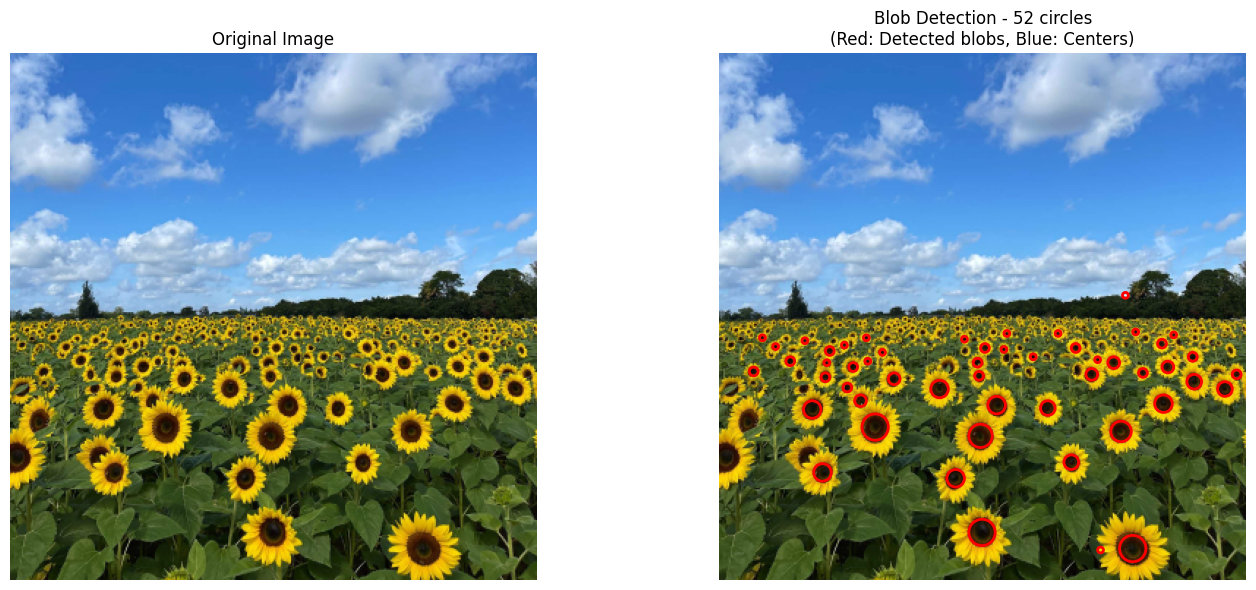


Top 5 largest blobs:
Rank | Center (x,y) | Radius | Sigma | Response
-------------------------------------------------------
   1 | (258.0, 209.0) |    2.0 |  1.41 | 0.1447
   2 | (323.0, 207.0) |    3.0 |  2.12 | 0.1433
   3 | (269.0, 211.0) |    4.0 |  2.83 | 0.1368
   4 | (306.0, 214.0) |    4.0 |  2.83 | 0.1271
   5 | (119.0, 222.0) |    4.0 |  2.83 | 0.1268

Visualizing LoG kernels...


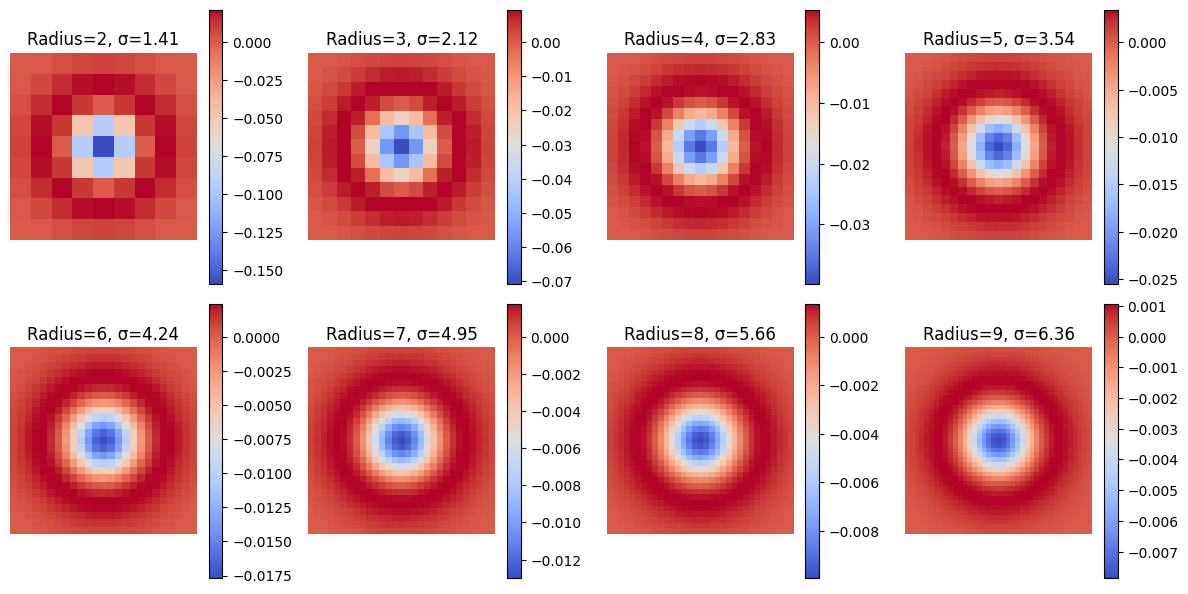


Visualizing responses at different scales...


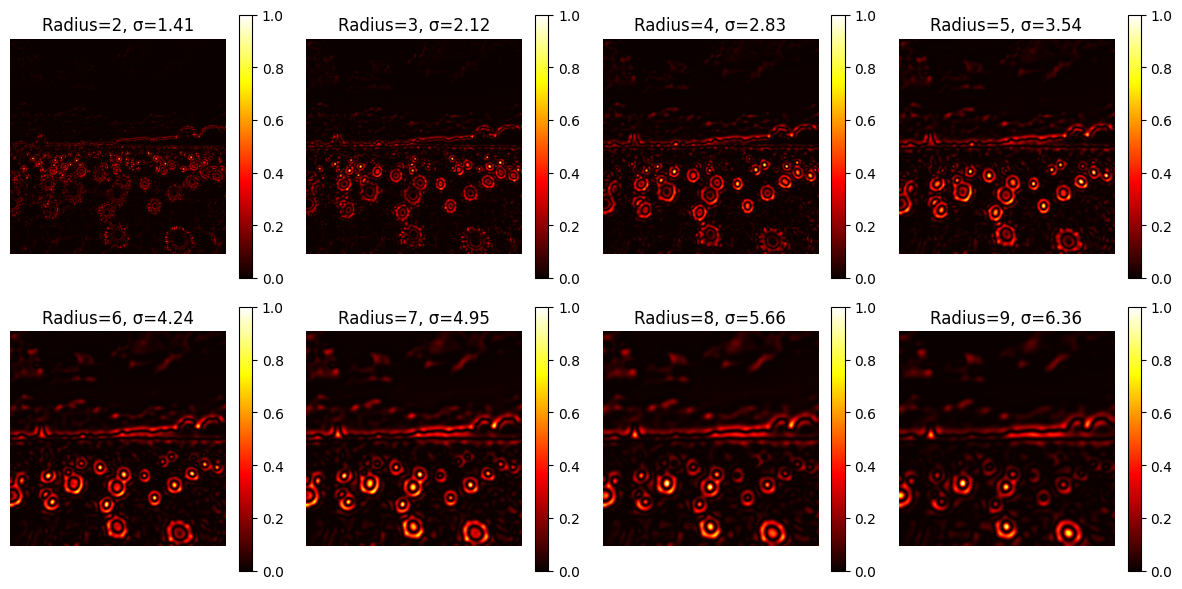

In [6]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def create_laplacian_of_gaussian_kernel(sigma):
    """
    Create CORRECT Laplacian of Gaussian kernel with proper normalization
    """
    # Determine kernel size (standard: 6*sigma)
    hw = int(3 * sigma)  # Half width
    size = 2 * hw + 1    # Ensure odd size
    
    # Create coordinate grid
    x = np.arange(-hw, hw + 1)
    y = np.arange(-hw, hw + 1)
    X, Y = np.meshgrid(x, y)
    
    # CORRECT Laplacian of Gaussian formula
    r_squared = X**2 + Y**2
    log_kernel = ((r_squared) / (2 * sigma**2) - 1) * np.exp(-r_squared / (2 * sigma**2)) / (np.pi * sigma**4)
    
    # Scale by sigma^2 for scale invariance
    scaled_log_kernel = (sigma ** 2) * log_kernel
    #scaled_log_kernel = np.exp(-r_squared / (2 * sigma**2)) * (r_squared-2*sigma**2)
    
    return scaled_log_kernel

# Load the image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
gray = gray.astype(np.float32) / 255.0

print(f"Image size: {gray.shape}")

# Step 1: Define sigma values (now representing radii) - CHANGED TO 6-10
radius_start = 2
radius_end = 9  # CHANGED FROM 15 TO 10
num_scales = radius_end-radius_start+1   # CHANGED FROM 10 TO 5 (since we have fewer radii)
radii = np.arange(radius_start, radius_end + 1)
sigma_values = radii / np.sqrt(2)  # Convert radius to sigma: σ = r/√2

print(f"Radii: {radii}")
print(f"Sigma values: {sigma_values}")

# Step 2 & 3: Create scaled Laplacian of Gaussian kernels and convolve with image
h, w = gray.shape
scale_space = np.zeros((h, w, num_scales), dtype=np.float32)

for i, sigma in enumerate(sigma_values):
    print(f"Processing sigma = {sigma:.2f} (radius = {radii[i]})")
    
    # Create CORRECT scaled Laplacian of Gaussian kernel
    log_kernel = create_laplacian_of_gaussian_kernel(sigma)
    
    # Convolve with image and SQUARE the response
    response = cv.filter2D(gray, cv.CV_32F, log_kernel)
    squared_response = np.square(response)  # Make all responses positive
    
    # Store in scale space
    scale_space[:, :, i] = squared_response

# Step 4: Find LOCAL MAXIMA (not minima) in scale-space
blobs = []

# Search for local maxima in 3D scale space
for scale_idx in range(num_scales):
    sigma = sigma_values[scale_idx]
    radius = radii[scale_idx]  # Direct radius value
    current_response = scale_space[:, :, scale_idx]
    
    print(f"Finding maxima for radius={radius}, sigma={sigma:.2f}")
    
    # SIMPLE neighborhood search (3x3)
    k = 1  # Neighborhood size
    
    # NEW: Calculate adaptive threshold for each scale
    # Use percentile to automatically set threshold (removes sky blobs)
    scale_threshold = np.percentile(current_response, 99.97)  # Top 5% strongest responses
    
    for y in range(k, h - k):
        for x in range(k, w - k):
            current_val = current_response[y, x]
            
            # Skip if below threshold - NEW CONDITION TO REMOVE SKY BLOBS
            if current_val < scale_threshold:  # CHANGED FROM FIXED TO ADAPTIVE THRESHOLD
                continue
            
            # Check if this is a local maximum in 3x3 neighborhood
            is_maximum = True
            for dy in range(-k, k + 1):
                for dx in range(-k, k + 1):
                    if dy == 0 and dx == 0:
                        continue
                    if current_response[y + dy, x + dx] > current_val:
                        is_maximum = False
                        break
                if not is_maximum:
                    break
            
            # Check scale-space: compare with adjacent scales
            if is_maximum and scale_idx > 0:
                if current_val < scale_space[y, x, scale_idx - 1]:
                    is_maximum = False
            
            if is_maximum and scale_idx < num_scales - 1:
                if current_val < scale_space[y, x, scale_idx + 1]:
                    is_maximum = False
            
            # If it's a true 3D maximum, record it
            if is_maximum:
                blobs.append((x, y, radius, sigma, current_val))

print(f"Found {len(blobs)} blob candidates")

# Remove duplicates - keep the strongest response for each location
final_blobs = []

# Sort by response strength (strongest first)
blobs.sort(key=lambda x: x[4], reverse=True)

for blob in blobs:
    x, y, radius, sigma, response = blob
    
    # Check if this location is already used
    location_used = False
    for existing_x, existing_y, existing_radius, _, _ in final_blobs:
        distance = np.sqrt((x - existing_x)**2 + (y - existing_y)**2)
        # If centers are closer than the smaller radius, skip
        if distance < min(radius, existing_radius):
            location_used = True
            break
    
    if not location_used:
        final_blobs.append(blob)

print(f"After duplicate removal: {len(final_blobs)} blobs")

# Step 5: Draw circles on output image using matplotlib
plt.figure(figsize=(15, 6))

# Create subplot for original image
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Create subplot for detected blobs
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
ax = plt.gca()

# Draw all detected blobs
for i, (x, y, radius, sigma, response) in enumerate(final_blobs):
    # Draw circle
    circle = plt.Circle((x, y), radius, color='red', linewidth=2, fill=False)
    ax.add_patch(circle)
    
    # Draw center point
    #plt.plot(x, y, 'b+', markersize=8, markeredgewidth=2)

plt.title(f"Blob Detection - {len(final_blobs)} circles\n(Red: Detected blobs, Blue: Centers)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Report results
if final_blobs:
    print(f"\nTop 5 largest blobs:")
    print("Rank | Center (x,y) | Radius | Sigma | Response")
    print("-" * 55)
    for i, (x, y, radius, sigma, response) in enumerate(final_blobs[:5]):
        print(f"{i+1:4d} | ({x:5.1f}, {y:5.1f}) | {radius:6.1f} | {sigma:5.2f} | {response:.4f}")

# Optional: Visualize LoG kernels for different scales
print(f"\nVisualizing LoG kernels...")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # CHANGED TO 3x3 GRID
sample_radii = radii  # CHANGED TO USE ALL RADII WE ACTUALLY USE
sample_sigmas = sigma_values  # CHANGED TO USE ALL SIGMAS WE ACTUALLY USE

for i, (radius, sigma) in enumerate(zip(sample_radii, sample_sigmas)):
    kernel = create_laplacian_of_gaussian_kernel(sigma)
    ax = axes[i//4, i%4]
    im_plot = ax.imshow(kernel, cmap='coolwarm')
    ax.set_title(f'Radius={radius}, σ={sigma:.2f}')
    ax.axis('off')
    plt.colorbar(im_plot, ax=ax)

# Hide any empty subplots if we have less than 9
for i in range(len(sample_radii)):
    axes[i//4, i%4].axis('off')

plt.tight_layout()
plt.show()

# Additional: Show response images at different scales
print(f"\nVisualizing responses at different scales...")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # CHANGED TO 3x3 GRID
sample_scale_indices = list(range(num_scales))  # CHANGED TO SHOW ALL SCALES

for i, scale_idx in enumerate(sample_scale_indices):
    ax = axes[i//4, i%4]
    response_img = scale_space[:, :, scale_idx]
    # Normalize for visualization
    response_normalized = (response_img - response_img.min()) / (response_img.max() - response_img.min())
    im_plot = ax.imshow(response_normalized, cmap='hot')
    ax.set_title(f'Radius={radii[scale_idx]}, σ={sigma_values[scale_idx]:.2f}')
    ax.axis('off')
    plt.colorbar(im_plot, ax=ax)

# Hide any empty subplots if we have less than 9
for i in range(len(sample_scale_indices)):
    axes[i//4, i%4].axis('off')

plt.tight_layout()
plt.show()